## IMPORT

In [1]:
import rasterio
from rasterio.windows import Window
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from unet_parts import *
from datetime import datetime
from tqdm import tqdm
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd
from utils import metrics
import matplotlib.patches as mpatches
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, IoU, ConfusionMatrix
from skimage.exposure import rescale_intensity
import pickle
import tikzplotlib

In [2]:
legend = pd.read_excel('../dataset_ICCV/legend.xlsx', usecols=[0,1,7])

In [3]:
class Formatter(object):
    def __init__(self, im):
        self.im = im

    def __call__(self, x, y):
        z = self.im.get_array()[int(y), int(x)]
        return f"{legend.iloc[z]['Name']}"

In [4]:
def saturate_plot(image):
    return rescale_intensity(
        image,
        in_range=(
            np.nanquantile(image, 0.01),
            np.nanquantile(image, 0.99),
        ),
    )

In [5]:
raster_dirs = {
    'orthophoto': '/CatLCNet/ORTHO/ORTHO_CAT_2018_UTM_WGS84_31N_1m.tif',
    'orthophotoIR': '/CatLCNet/ORTHO/ORTHOIR_CAT_2018.tif',
    'sentinel1': '/CatLCNet/S1/S1_CAT_GRD_ASC_VV_2018_UTM_WGS84_31N_10m.tif',
    'sentinel2april': '/CatLCNet/S2/S2_CAT_201804_UTM_WGS84_31N_10m.tif',
    'sentinel2august': '/CatLCNet/S2/S2_CAT_201808_UTM_WGS84_31N_10m.tif',
    'landcover': '/CatLCNet/LC/LC_2018_UTM_WGS84_31N_1m.tif',
    'dsm':'/CatLCNet/DEM/DSM_CAT_10m_2018_v1.tif',
    'chm':'/CatLCNet/DEM/CHM_CAT_10m_2018_v1.tif'
}

In [6]:
no_borders = np.load('../dataset_ICCV/no_borders_960.npy', allow_pickle=True)
no_borders_indexes = np.arange(0,len(no_borders))
np.random.seed(88) # 88 i 6910 good distribution of data
np.random.shuffle(no_borders_indexes)
no_borders = no_borders[no_borders_indexes]
no_borders_train = no_borders[:(int)(0.6*len(no_borders))]
no_borders_val = no_borders[(int)(0.6*len(no_borders)):(int)(0.8*len(no_borders))]
no_borders_test = no_borders[(int)(0.8*len(no_borders)):]

In [7]:
class CustomExponential:
    def __init__(self, value):
        self.value = int(np.log10(value))
    def __str__(self):
        return 'e{self.value}'.format(self=self)

## DATALOADER

In [8]:
class Normalize(object):
    """Normalize images."""

    def __call__(self, sample):
                        
        landcover = sample['landcover']
        subdataset = sample['subdataset']
        tile = sample['tile']
        raster_stats = pd.read_pickle('raster_stats.pkl')
        
        if subdataset == None:
            sample = {}
        
        if subdataset=='ortho' or subdataset=='complete':
            orthophoto, orthophotoIR = sample['orthophoto'], sample['orthophotoIR']
            stats_orthophoto = raster_stats.iloc[0:3]
            normalize_orthophoto = transforms.Normalize(stats_orthophoto['mean'].to_numpy(),stats_orthophoto['std'].to_numpy())
            orthophoto = normalize_orthophoto(orthophoto)
            stats_orthophotoIR = raster_stats.iloc[3]
            normalize_orthophotoIR = transforms.Normalize(stats_orthophotoIR['mean'],stats_orthophotoIR['std'])
            orthophotoIR = normalize_orthophotoIR(orthophotoIR)
            if not sample['subdataset'] == 'complete': sample = {'orthophoto': orthophoto, 'orthophotoIR': orthophotoIR}
            
        if subdataset == 'sentinel1' or subdataset=='complete':
            sentinel1 = sample['sentinel1']
            stats_sentinel1 = raster_stats.iloc[4]
            normalize_sentinel1 = transforms.Normalize(stats_sentinel1['mean'],stats_sentinel1['std'])
            sentinel1 = normalize_sentinel1(sentinel1)
            if not sample['subdataset'] == 'complete': sample = {'sentinel1': sentinel1}
            
        if subdataset == 'sentinel2' or subdataset=='complete':
            sentinel2april, sentinel2august = sample['sentinel2april'], sample['sentinel2august']
            stats_sentinel2april = raster_stats.iloc[5:15]
            normalize_sentinel2april = transforms.Normalize(stats_sentinel2april['mean'].to_numpy(),stats_sentinel2april['std'].to_numpy())
            sentinel2april = normalize_sentinel2april(sentinel2april)
            stats_sentinel2august = raster_stats.iloc[15:25]
            normalize_sentinel2august = transforms.Normalize(stats_sentinel2august['mean'].to_numpy(),stats_sentinel2august['std'].to_numpy())
            sentinel2august = normalize_sentinel2august(sentinel2august)
            if not sample['subdataset'] == 'complete': sample = {'sentinel2april': sentinel2april, 'sentinel2august': sentinel2august}
            
        if subdataset == 'topographic' or subdataset=='complete':
            dsm, chm = sample['dsm'], sample['chm']
            stats_dsm = raster_stats.iloc[25]
            normalize_dsm = transforms.Normalize(stats_dsm['mean'],stats_dsm['std'])
            dsm = normalize_dsm(dsm)
            stats_chm = raster_stats.iloc[26]
            normalize_chm = transforms.Normalize(stats_chm['mean'],stats_chm['std'])
            chm = normalize_chm(chm)
            if not sample['subdataset'] == 'complete': sample = {'dsm': dsm, 'chm': chm}
            
        if subdataset == 'complete':
            sample = {'orthophoto': orthophoto, 'orthophotoIR': orthophotoIR, 'sentinel1': sentinel1,
                      'sentinel2april': sentinel2april, 'sentinel2august': sentinel2august, 'dsm': dsm, 'chm': chm}
        
        sample['tile'] = tile
        sample['landcover'] = landcover
        
        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
                
        landcover = torch.from_numpy(sample['landcover']-1)
        subdataset = sample['subdataset']
        tile = sample['tile']
        
        if subdataset == None:
            sample = {}
        
        if subdataset == 'ortho' or subdataset=='complete':
            orthophoto, orthophotoIR = sample['orthophoto'], sample['orthophotoIR']
            orthophoto = torch.from_numpy(orthophoto.astype(np.float32))
            orthophotoIR = torch.from_numpy(orthophotoIR.astype(np.float32))
            if not subdataset == 'complete': sample = {'orthophoto': orthophoto, 'orthophotoIR': orthophotoIR}
            
        if subdataset == 'sentinel1' or subdataset=='complete':
            sentinel1 = sample['sentinel1']
            sentinel1 = torch.from_numpy(sentinel1.astype(np.float32))
            if not subdataset == 'complete': sample = {'sentinel1': sentinel1}
            
        if subdataset == 'sentinel2' or subdataset=='complete':
            sentinel2april, sentinel2august = sample['sentinel2april'], sample['sentinel2august']
            sentinel2april = torch.from_numpy(sentinel2april.astype(np.float32))
            sentinel2august = torch.from_numpy(sentinel2august.astype(np.float32))
            if not subdataset == 'complete': sample = {'sentinel2april': sentinel2april, 'sentinel2august': sentinel2august}
            
        if subdataset == 'topographic' or subdataset=='complete':
            dsm, chm = sample['dsm'], sample['chm']
            dsm = torch.from_numpy(dsm.astype(np.float32))
            chm = torch.from_numpy(chm.astype(np.float32))
            if not subdataset == 'complete': sample = {'dsm': dsm, 'chm': chm}
            
        if subdataset == 'complete':
            sample = {'orthophoto': orthophoto, 'orthophotoIR': orthophotoIR, 'sentinel1': sentinel1,
                      'sentinel2april': sentinel2april, 'sentinel2august': sentinel2august, 'dsm': dsm, 'chm': chm}            
            
        sample['tile'] = tile
        sample['subdataset'] = subdataset
        sample['landcover'] = landcover
        
        return sample

In [9]:
class CatalanDataset(Dataset):
    def __init__(self, tiles_list, raster_dirs, shape=960, transform=None, subdataset='ortho'): #960, to train 320
                    
        """
        Args:
            tiles_list (): Path to the csv file with annotations.
            raster_dirs (): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.tiles_list = tiles_list
        self.raster_dirs = raster_dirs
        self.transform = transform
        self.shape = shape
        self.subdataset = subdataset
        

    def __len__(self):
        return len(self.tiles_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        position = self.tiles_list[idx] + np.random.randint(low=0, high=961-self.shape, size=(2)) # if tile smaller than shape of the images, random take a part inside it
        window_1m = Window(*position, self.shape, self.shape)
        
        with rasterio.open(self.raster_dirs['landcover']) as src:
            raster_landcover = src.read(window=window_1m) # (1,shape,shape) uint8
            
        if self.subdataset == 'ortho' or self.subdataset=='complete':            

            with rasterio.open(self.raster_dirs['orthophoto']) as src:
                raster_orthophoto = src.read(window=window_1m) # (3, shape, shape) uint8
            with rasterio.open(self.raster_dirs['orthophotoIR']) as src:
                raster_orthophotoIR = src.read(window=window_1m) # (3, shape, shape) uint8
            if not self.subdataset == 'complete': sample = {'orthophoto': raster_orthophoto, 'orthophotoIR': raster_orthophotoIR}
            
                
        if self.subdataset == 'sentinel1' or self.subdataset=='complete':
            
            window_10m = Window(*position // 10, self.shape//10, self.shape//10)     
            with rasterio.open(self.raster_dirs['sentinel1']) as src:
                raster_sentinel1 = src.read(window=window_10m)
            if not self.subdataset == 'complete': sample = {'sentinel1': raster_sentinel1,}
                
        if self.subdataset == 'sentinel2' or self.subdataset=='complete':
            
            window_10m = Window(*position // 10, self.shape//10, self.shape//10)            
            with rasterio.open(self.raster_dirs['sentinel2april']) as src:
                raster_sentinel2april = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m)            
            with rasterio.open(self.raster_dirs['sentinel2april']) as src:
                raster_sentinel2august = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m)
            if not self.subdataset == 'complete': sample = {'sentinel2april': raster_sentinel2april, 'sentinel2august': raster_sentinel2august}
        
                
        if self.subdataset == 'topographic' or self.subdataset=='complete':
            
#             window_5m = Window(*position // 5, self.shape//5, self.shape//5)      
#             with rasterio.open(self.raster_dirs['dem']) as src:
#                 raster_dem = src.read(window=window_5m)

            window_10m = Window(*position // 10, self.shape//10, self.shape//10)   
            with rasterio.open(self.raster_dirs['dsm']) as src:
                raster_dsm = src.read(window=window_10m)              
            with rasterio.open(self.raster_dirs['chm']) as src:
                raster_chm = src.read(window=window_10m)
            if not self.subdataset == 'complete': sample = {'dsm': raster_dsm, 'chm': raster_chm}
            
        if self.subdataset == 'complete':
            sample = {'orthophoto': raster_orthophoto, 'orthophotoIR': raster_orthophotoIR, 'sentinel1': raster_sentinel1,
                      'sentinel2april': raster_sentinel2april, 'sentinel2august': raster_sentinel2august, 'dsm': raster_dsm, 'chm': raster_chm}
            
        if self.subdataset == None:
            sample = {}
            
        sample['tile'] = idx
        sample['landcover'] = raster_landcover
        sample['subdataset'] = self.subdataset                    
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
metric_collection = MetricCollection([
    ConfusionMatrix(num_classes=41),
    IoU(num_classes=41, reduction='none')    
])
metric_collection.reset()

## HISTOGRAM

In [ ]:
# while(True): #commentaries used to find a good distribution of the train, eval, test data
    
no_borders_indexes = np.arange(0,len(no_borders))
no_borders = np.load('../dataset_ICCV/no_borders_960.npy', allow_pickle=True)

seed = np.random.randint(0,10000)
np.random.seed(6910) #6910 goo distribution
np.random.shuffle(no_borders_indexes)
no_borders = no_borders[no_borders_indexes]

no_borders_train = no_borders[:(int)(0.6*len(no_borders))]
no_borders_val = no_borders[(int)(0.6*len(no_borders)):(int)(0.8*len(no_borders))]
no_borders_test = no_borders[(int)(0.8*len(no_borders)):]

CatLC_ortho_train = CatalanDataset(no_borders_train, raster_dirs, subdataset=None, shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_val = CatalanDataset(no_borders_val, raster_dirs, subdataset=None, shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_test = CatalanDataset(no_borders_test, raster_dirs, subdataset=None, shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))

train_loader = DataLoader(CatLC_ortho_train, batch_size=64, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_ortho_val, batch_size=64, shuffle=True, num_workers=20)
test_loader = DataLoader(CatLC_ortho_test, batch_size=64, shuffle=True, num_workers=20)

train_histogram = torch.zeros(41)
val_histogram = torch.zeros(41)
test_histogram = torch.zeros(41)

with tqdm(train_loader) as t:
    for batch_idx, data in enumerate(t):
        train_histogram += torch.histc(data['landcover'].float(), bins=41, min=0, max=40)
#             if (train_histogram!=0).all(): break
#         if (train_histogram==0).any(): continue

with tqdm(val_loader) as t:
    for batch_idx, data in enumerate(t):
        val_histogram += torch.histc(data['landcover'].float(), bins=41, min=0, max=40)
#             if (val_histogram!=0).all(): break
#         if (val_histogram==0).any(): continue

with tqdm(test_loader) as t:
    for batch_idx, data in enumerate(t):
        test_histogram += torch.histc(data['landcover'].float(), bins=41, min=0, max=40)
#         if (test_histogram!=0).all(): break
#         if (test_histogram==0).any(): continue
#         print(seed)
#         break

In [88]:
df = pd.DataFrame(np.array([train_histogram.numpy(),val_histogram.numpy(),test_histogram.numpy()]).T, columns=['Train','Validation','Test'])
total = df['Train']+df['Validation']+df['Test']

<AxesSubplot:>

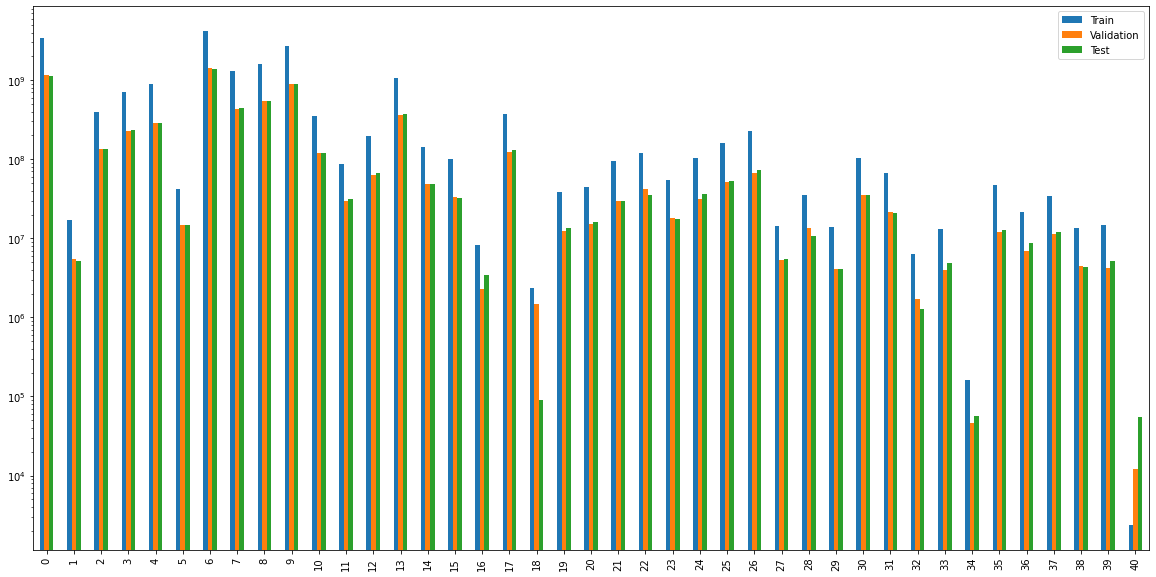

In [89]:
df.plot(kind='bar', figsize=(20,10), logy=True)

## MODEL

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, resolution=None, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.resolution = resolution
        
        if self.resolution == 'low_resolution':
            self.up0 = nn.Upsample((120,120), mode='bilinear', align_corners=False)
        else:
            pass

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        if self.resolution == 'low_resolution' or self.resolution == 'mid_resolution':
            x = self.up0(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
def save_model(name, epoch, model, optimizer, train_losses, val_losses):
    PATH = f'saved_models/{name}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, PATH)

In [15]:
with open('../dataset_ICCV/cmap_mcsc.pickle', 'rb') as f:
    cmap_mcsc = np.load(f, allow_pickle=True)
with open('../dataset_ICCV/norm_mcsc.pickle', 'rb') as f:
    norm_mcsc = np.load(f, allow_pickle=True)

In [16]:
def plot_figure():
    
    %matplotlib inline

    data = next(iter(test_loader))

    tile = no_borders_test[data['tile']]
    fig, axs = plt.subplots(1,3, figsize=(14,5))

    window = Window(*tile, 320, 320)
    with rasterio.open(raster_dirs['orthophoto']) as src:
        pic = src.read(window=window)
    axs[0].imshow(np.moveaxis(pic,0,-1))
    axs[0].set_title('Orthophoto')

    with rasterio.open(raster_dirs['landcover']) as src:
        pic_landcover = src.read(window=window) - 1
    plot_landcover = axs[1].imshow(pic_landcover[0], cmap=cmap_mcsc, vmin=0, vmax=41, interpolation='none')
    axs[1].set_title('landcover')
    axs[1].format_coord = Formatter(plot_landcover)

    input_data_highres = torch.cat((data['orthophoto'], data['orthophotoIR']), 1)

    prediction = model(input_data_highres.to(device))
    prediction = torch.max(prediction, 1)[1][0].cpu()
    labels = data['landcover'].squeeze().long().cpu()

    plot_prediction = axs[2].imshow(prediction, cmap=cmap_mcsc, vmin=0, vmax=41, interpolation='none')
    axs[2].set_title(f'prediction. acc: {torch.sum(prediction==labels)/labels.nelement():.2f}, iou: {metrics.mean_iou(prediction, labels, 41):.2f}')
    #axs[2].set_title(f'prediction, accuracy: {100*np.sum(torch.max(prediction, 1)[1].cpu() == pic_landcover[0])/pic_landcover.size:.2f}%')
    axs[2].format_coord = Formatter(plot_prediction)

    classes_in_images = np.unique([prediction.numpy(),labels.numpy()])
    patches =[mpatches.Patch(color=cmap_mcsc.colors[i],label=legend.iloc[i]['Name']+f' ({i+1})') for i in classes_in_images]
    fig.legend(handles=patches, loc='lower center', ncol = (len(patches) if len(patches) < 6 else 5))

    fig.suptitle(f'Tile {tile}')
    
    return fig

## ORTHO TRAIN

In [134]:
model = UNet(n_channels=4, n_classes=41, bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [135]:
name = datetime.now().strftime("%d-%m-%Hh%Mm") + '-unet_ortho_simple'
print(name)

15-07-03h24m-unet_ortho_simple


In [140]:
CatLC_ortho_train = CatalanDataset(no_borders_train, raster_dirs, subdataset='ortho', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_val = CatalanDataset(no_borders_val, raster_dirs, subdataset='ortho', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_test = CatalanDataset(no_borders_test, raster_dirs, subdataset='ortho', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))

In [141]:
train_loader = DataLoader(CatLC_ortho_train, batch_size=16, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_ortho_val, batch_size=16, shuffle=True, num_workers=10)
test_loader = DataLoader(CatLC_ortho_test, batch_size=5, shuffle=True, num_workers=1)

In [ ]:
for epoch in range(0, 80):
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (train_loader.__len__())
    )
    with tqdm(train_loader) as t:
        for batch_idx, data in enumerate(t):

            model.train()
            # data
            labels, inputs_highres = data['landcover'], torch.cat((data['orthophoto'], data['orthophotoIR']), 1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_highres = inputs_highres.to(device)

            # forward
            optimizer.zero_grad()

            outputs = model(inputs_highres)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            loss_per_batch[batch_idx] = loss.item()
            
            loss.backward()
            optimizer.step()
            
            accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()
            
            t.set_postfix({"batch_idx": batch_idx,
                            "Loss": loss.item(),
                            "Accuracy (%)": accuracy.item(),
                            "Learning rate": optimizer.param_groups[0]["lr"],})
            
        loss_per_epoch = torch.mean(loss_per_batch)
        t.set_postfix({"Total loss": loss_per_epoch.item()})
        train_losses.append(loss_per_epoch.item())        
            
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (val_loader.__len__())
    )            
    with tqdm(val_loader) as t:
        for batch_idx, data in enumerate(t):

            model.eval()
            # data
            labels, inputs_highres = data['landcover'], torch.cat((data['orthophoto'], data['orthophotoIR']), 1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_highres = inputs_highres.to(device)

            # forward
            with torch.no_grad():

                outputs = model(inputs_highres)

                loss = criterion(outputs, labels)
                loss = loss.mean()

                loss_per_batch[batch_idx] = loss.item()

                accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()

                t.set_postfix({"batch_idx": batch_idx,
                                "Loss": loss.item(),
                                "Accuracy (%)": accuracy.item(),
                                "Learning rate": optimizer.param_groups[0]["lr"],})

        loss_per_epoch = torch.mean(loss_per_batch).item()
        t.set_postfix({"Total loss": loss_per_epoch})
        
        if any([loss_per_epoch > i for i in val_losses]) and epoch != 0:
            patience += 1
        else:
            patience = 0
            save_model(name, epoch, model, optimizer, train_losses, val_losses)
        
        val_losses.append(loss_per_epoch)
        
    writer = SummaryWriter('logs/'+ name)
#     writer.add_figure('figure', plot_figure(), global_step=epoch);
    writer.add_scalars('Loss', {'Train': train_losses[epoch], 'Validation': val_losses[epoch]}, global_step=epoch)
    writer.close()
    
    if patience >= 20:
        break

 19%|█▉        | 247/1277 [03:44<15:29,  1.11it/s, batch_idx=246, Loss=1.54, Accuracy (%)=58.3, Learning rate=0.0001]

In [142]:
PATH = 'saved_models/01-06-20h18m-unet_ortho_simple'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()
with tqdm(test_loader) as t:
    for batch_idx, data in enumerate(t):
        with torch.no_grad():
            labels, inputs_orthophoto = data['landcover'], torch.cat((data['orthophoto'], data['orthophotoIR']), 1)     
            labels = torch.squeeze(labels.long(),1)
            labels = labels.to(device)
            
            inputs_orthophoto = inputs_orthophoto.to(device)
            
            outputs = model(inputs_orthophoto)
            preds = torch.max(outputs, 1)[1]
            
            metrics = metric_collection(preds.cpu(), labels.cpu())

  0%|          | 6/1362 [00:59<3:41:40,  9.81s/it]

In [ ]:
a_file = open("metrics/metrics_ortho.pkl", "wb")
pickle.dump(metric_collection.compute(), a_file)

In [143]:
stats_ortho = pd.read_pickle('raster_stats.pkl').iloc[0:4]

inv_normalize = transforms.Normalize(
   mean= -stats_ortho['mean']/stats_ortho['std'],
   std= 1/stats_ortho['std']
)

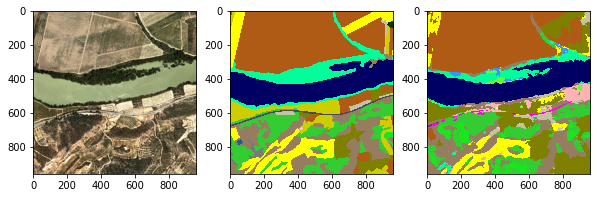

In [152]:
model.eval()
#next(iter(test_loader))
# labels, inputs_ortho = data['landcover'], torch.cat((data['orthophoto'], data['orthophotoIR']), 1) # to test with random images
data = CatLC_ortho_test[4570]
labels, inputs_ortho = data['landcover'], torch.unsqueeze(torch.cat((data['orthophoto'], data['orthophotoIR']), 0),0) # to use same image for all experiments
inputs_ortho = inputs_ortho.to(device)

with torch.no_grad():
    outputs = model(inputs_ortho)
    preds = torch.max(outputs, 1)[1].cpu()
    
fig, axs = plt.subplots(1,3,figsize=(10,3))
inputs_ortho = np.moveaxis(inv_normalize(inputs_ortho[0]).cpu().numpy(),0,2)
axs[0].imshow(saturate_plot(inputs_ortho[...,0:3]))
axs[1].imshow(labels[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none') # [0][0] for random [0] for compare
axs[2].imshow(preds[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')

In [150]:
from PIL import Image

im = Image.fromarray(np.uint8(saturate_plot(inputs_highres[0])*255))
im.save("pred_ortho.png")

im = Image.fromarray(np.uint8(cmap_mcsc(labels[0][0])*255))
im.save("pred_label.png")

im = Image.fromarray(np.uint8(cmap_mcsc(preds[0])*255))
im.save("pred_pred.png")

## SENTINEL 1 TRAIN

In [25]:
name = datetime.now().strftime("%d-%m-%Hh%Mm") + '-unet_sentinel1_simple'
print(name)

11-07-18h08m-unet_sentinel1_simple


In [101]:
CatLC_ortho_train = CatalanDataset(no_borders_train, raster_dirs, subdataset='sentinel1', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_val = CatalanDataset(no_borders_val, raster_dirs, subdataset='sentinel1', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_test = CatalanDataset(no_borders_test, raster_dirs, subdataset='sentinel1', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))

In [102]:
train_loader = DataLoader(CatLC_ortho_train, batch_size=64, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_ortho_val, batch_size=64, shuffle=True, num_workers=20)
test_loader = DataLoader(CatLC_ortho_test, batch_size=1, shuffle=True, num_workers=1)

In [59]:
model = UNet(n_channels=1, n_classes=41, resolution='low_resolution', bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [29]:
train_losses = []
val_losses = []
patience = 0
for epoch in range(0, 80):
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (train_loader.__len__())
    )
    with tqdm(train_loader) as t:
        for batch_idx, data in enumerate(t):

            model.train()
            # data
            labels, inputs_sentinel1 = data['landcover'], data['sentinel1']
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_sentinel1 = inputs_sentinel1.to(device)

            # forward
            optimizer.zero_grad()

            outputs = model(inputs_sentinel1)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            loss_per_batch[batch_idx] = loss.item()
            
            loss.backward()
            optimizer.step()
            
            accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()
            
            t.set_postfix({"batch_idx": batch_idx,
                            "Loss": loss.item(),
                            "Accuracy (%)": accuracy.item(),
                            "Learning rate": optimizer.param_groups[0]["lr"],})
            
        loss_per_epoch = torch.mean(loss_per_batch)
        t.set_postfix({"Total loss": loss_per_epoch.item()})
        train_losses.append(loss_per_epoch.item())        
            
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (val_loader.__len__())
    )            
    with tqdm(val_loader) as t:
        for batch_idx, data in enumerate(t):

            model.eval()
            # data
            labels, inputs_sentinel1 = data['landcover'], data['sentinel1']
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_sentinel1 = inputs_sentinel1.to(device)

            # forward
            with torch.no_grad():

                outputs = model(inputs_sentinel1)

                loss = criterion(outputs, labels)
                loss = loss.mean()

                loss_per_batch[batch_idx] = loss.item()

                accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()

                t.set_postfix({"batch_idx": batch_idx,
                                "Loss": loss.item(),
                                "Accuracy (%)": accuracy.item(),
                                "Learning rate": optimizer.param_groups[0]["lr"],})

        loss_per_epoch = torch.mean(loss_per_batch).item()
        t.set_postfix({"Total loss": loss_per_epoch})
        
        if any([loss_per_epoch > i for i in val_losses]) and epoch != 0:
            patience += 1
        else:
            patience = 0
            save_model(name, epoch, model, optimizer, train_losses, val_losses)
        
        val_losses.append(loss_per_epoch)
        
    writer = SummaryWriter('logs/'+ name)
#     writer.add_figure('figure', plot_figure(), global_step=epoch);
    writer.add_scalars('Loss', {'Train': train_losses[epoch], 'Validation': val_losses[epoch]}, global_step=epoch)
    writer.close()
    
    if patience >= 5:
        break

  1%|          | 2/320 [00:03<09:12,  1.74s/it, batch_idx=1, Loss=2.18, Accuracy (%)=36.7, Learning rate=0.0001]


KeyboardInterrupt: 

In [103]:
model = UNet(n_channels=1, n_classes=41, resolution='low_resolution', bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [104]:
PATH = 'saved_models/11-07-18h08m-unet_sentinel1_simple'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [105]:
stats_sentinel1 = pd.read_pickle('raster_stats.pkl').iloc[4]

inv_normalize = transforms.Normalize(
   mean= -stats_sentinel1['mean']/stats_sentinel1['std'],
   std= 1/stats_sentinel1['std']
)

In [116]:
model.eval()
data = next(iter(test_loader))
labels, inputs_sentinel1 = data['landcover'], data['sentinel1']
inputs_sentinel1 = inputs_sentinel1.to(device)

with torch.no_grad():
    outputs = model(inputs_sentinel1)
    preds = torch.max(outputs, 1)[1].cpu()

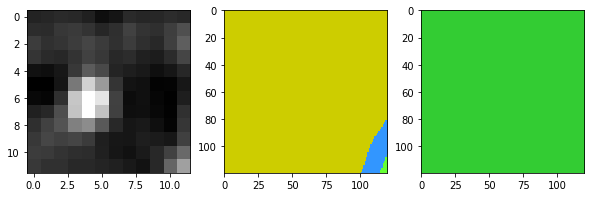

In [117]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
inputs_highres = np.moveaxis(inv_normalize(inputs_sentinel1[0]).cpu().numpy(),0,2)
axs[0].imshow(saturate_plot(inputs_highres), cmap='gray')
axs[1].imshow(labels[0][0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')
axs[2].imshow(preds[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')

## SENTINEL 2 TRAIN

In [50]:
name = datetime.now().strftime("%d-%m-%Hh%Mm") + '-unet_sentinel2_simple'
print(name)

15-07-03h10m-unet_sentinel2_simple


In [94]:
CatLC_s2_train = CatalanDataset(no_borders_train, raster_dirs, subdataset='sentinel2', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_s2_val = CatalanDataset(no_borders_val, raster_dirs, subdataset='sentinel2', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_s2_test = CatalanDataset(no_borders_test, raster_dirs, subdataset='sentinel2', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))

In [95]:
train_loader = DataLoader(CatLC_s2_train, batch_size=20, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_s2_val, batch_size=20, shuffle=True, num_workers=20)
test_loader = DataLoader(CatLC_s2_test, batch_size=1, shuffle=False, num_workers=1)

In [96]:
model = UNet(n_channels=20, n_classes=41, resolution=None, bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
upsample_init = nn.Upsample((120,120), mode='bilinear', align_corners=False)

In [ ]:
train_losses = []
val_losses = []
patience = 0
for epoch in range(20):
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (train_loader.__len__())
    )
    with tqdm(train_loader) as t:
        for batch_idx, data in enumerate(t):

            model.train()
            # data
            labels, inputs_sentinel2 = data['landcover'], torch.cat((upsample_init(data['sentinel2april']),upsample_init(data['sentinel2august'])),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_sentinel2 = inputs_sentinel2.to(device)

            # forward
            optimizer.zero_grad()

            outputs = model(inputs_sentinel2)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            loss_per_batch[batch_idx] = loss.item()
            
            loss.backward()
            optimizer.step()
            
            accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()
            
            t.set_postfix({"batch_idx": batch_idx,
                            "Loss": loss.item(),
                            "Accuracy (%)": accuracy.item(),
                            "Learning rate": optimizer.param_groups[0]["lr"],})
            
        loss_per_epoch = torch.mean(loss_per_batch)
        t.set_postfix({"Total loss": loss_per_epoch.item()})
        train_losses.append(loss_per_epoch.item())        
            
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (val_loader.__len__())
    )            
    with tqdm(val_loader) as t:
        for batch_idx, data in enumerate(t):

            model.eval()
            # data
            labels, inputs_sentinel2 = data['landcover'], torch.cat((upsample_init(data['sentinel2april']),upsample_init(data['sentinel2august'])),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_sentinel2 = inputs_sentinel2.to(device)

            # forward
            with torch.no_grad():

                outputs = model(inputs_sentinel2)

                loss = criterion(outputs, labels)
                loss = loss.mean()

                loss_per_batch[batch_idx] = loss.item()

                accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()

                t.set_postfix({"batch_idx": batch_idx,
                                "Loss": loss.item(),
                                "Accuracy (%)": accuracy.item(),
                                "Learning rate": optimizer.param_groups[0]["lr"],})

        loss_per_epoch = torch.mean(loss_per_batch).item()
        t.set_postfix({"Total loss": loss_per_epoch})
        
        if any([loss_per_epoch > i for i in val_losses]) and epoch != 0:
            patience += 1
        else:
            patience = 0
            save_model(name, epoch, model, optimizer, train_losses, val_losses)
        
        val_losses.append(loss_per_epoch)
        
    writer = SummaryWriter('logs/'+ name)
#     writer.add_figure('figure', plot_figure(), global_step=epoch);
    writer.add_scalars('Loss', {'Train': train_losses[epoch], 'Validation': val_losses[epoch]}, global_step=epoch)
    writer.close()
    
    if patience >= 5:
        break

 54%|█████▎    | 183/341 [00:18<00:14, 10.89it/s, batch_idx=184, Loss=1.42, Accuracy (%)=48.5, Learning rate=0.0001] 

In [97]:
PATH = 'saved_models/13-07-11h22m-unet_sentinel2_simple'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [98]:
stats_sentinel2 = pd.read_pickle('raster_stats.pkl').iloc[5:25]

inv_normalize = transforms.Normalize(
   mean= -stats_sentinel2['mean'].to_numpy()/stats_sentinel2['std'].to_numpy(),
   std= 1/stats_sentinel2['std'].to_numpy()
)

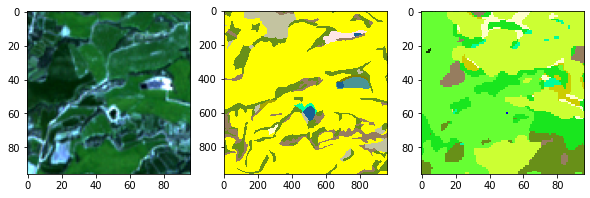

In [108]:
data = CatLC_s2_test[210]
# data = next(iter(test_loader))
labels, inputs_sentinel2 = data['landcover'], torch.unsqueeze(torch.cat((data['sentinel2april'],data['sentinel2august']),0),0)
inputs_sentinel2 = inputs_sentinel2.to(device)

with torch.no_grad():
    outputs = model(inputs_sentinel2)
    preds = torch.max(outputs, 1)[1].cpu()
    
fig, axs = plt.subplots(1,3,figsize=(10,3))
inputs_highres = np.moveaxis(inv_normalize(inputs_sentinel2[0]).cpu().numpy(),0,2)
axs[0].imshow(saturate_plot(inputs_highres[...,0:3]))
axs[1].imshow(labels[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')
axs[2].imshow(preds[0]+1, cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')

In [ ]:
upsample_init = nn.Upsample((960,960), mode='bilinear', align_corners=False) # gt images are 960x960 so we bring those small to this size too
model.eval()
with tqdm(test_loader) as t:
    for batch_idx, data in enumerate(t):
        with torch.no_grad():
            labels, inputs_sentinel2 = data['landcover'], torch.cat((upsample_init(data['sentinel2april']),upsample_init(data['sentinel2august'])),1)   
            labels = torch.squeeze(labels.long(),1)
            labels = labels.to(device)
            
            inputs_sentinel2 = inputs_sentinel2.to(device)
            
            outputs = model(inputs_sentinel2)
            preds = torch.max(outputs, 1)[1]
            
            metrics = metric_collection(preds.cpu(), labels.cpu())

In [ ]:
a_file = open("metrics/metrics_sentinel2.pkl", "wb")
pickle.dump(metric_collection.compute(), a_file)

## TOPOGRAPHIC TRAIN

In [15]:
name = datetime.now().strftime("%d-%m-%Hh%Mm") + '-unet_topographic_simple'
print(name)

12-07-09h47m-unet_topographic_simple


In [16]:
CatLC_ortho_train = CatalanDataset(no_borders_train, raster_dirs, subdataset='topographic', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_val = CatalanDataset(no_borders_val, raster_dirs, subdataset='topographic', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_ortho_test = CatalanDataset(no_borders_test, raster_dirs, subdataset='topographic', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))

In [17]:
train_loader = DataLoader(CatLC_ortho_train, batch_size=20, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_ortho_val, batch_size=20, shuffle=True, num_workers=20)
test_loader = DataLoader(CatLC_ortho_test, batch_size=4, shuffle=True, num_workers=20)

In [23]:
model = UNet(n_channels=2, n_classes=41, resolution='low_resolution', bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [24]:
train_losses = []
val_losses = []
patience = 0
for epoch in range(0, 80):
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (train_loader.__len__())
    )
    with tqdm(train_loader) as t:
        for batch_idx, data in enumerate(t):

            model.train()
            # data
            labels, inputs_topographic = data['landcover'], torch.cat((data['dsm'],data['chm']),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_topographic = inputs_topographic.to(device)

            # forward
            optimizer.zero_grad()

            outputs = model(inputs_topographic)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            loss_per_batch[batch_idx] = loss.item()
            
            loss.backward()
            optimizer.step()
            
            accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()
            
            t.set_postfix({"batch_idx": batch_idx,
                            "Loss": loss.item(),
                            "Accuracy (%)": accuracy.item(),
                            "Learning rate": optimizer.param_groups[0]["lr"],})
            
        loss_per_epoch = torch.mean(loss_per_batch)
        t.set_postfix({"Total loss": loss_per_epoch.item()})
        train_losses.append(loss_per_epoch.item())        
            
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (val_loader.__len__())
    )            
    with tqdm(val_loader) as t:
        for batch_idx, data in enumerate(t):

            model.eval()
            # data
            labels, inputs_topographic = data['landcover'], torch.cat((data['dsm'],data['chm']),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_topographic = inputs_topographic.to(device)

            # forward
            with torch.no_grad():

                outputs = model(inputs_topographic)

                loss = criterion(outputs, labels)
                loss = loss.mean()

                loss_per_batch[batch_idx] = loss.item()

                accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()

                t.set_postfix({"batch_idx": batch_idx,
                                "Loss": loss.item(),
                                "Accuracy (%)": accuracy.item(),
                                "Learning rate": optimizer.param_groups[0]["lr"],})

        loss_per_epoch = torch.mean(loss_per_batch).item()
        t.set_postfix({"Total loss": loss_per_epoch})
        
        if any([loss_per_epoch > i for i in val_losses]) and epoch != 0:
            patience += 1
        else:
            patience = 0
            save_model(name, epoch, model, optimizer, train_losses, val_losses)
        
        val_losses.append(loss_per_epoch)
        
    writer = SummaryWriter('logs/'+ name)
#     writer.add_figure('figure', plot_figure(), global_step=epoch);
    writer.add_scalars('Loss', {'Train': train_losses[epoch], 'Validation': val_losses[epoch]}, global_step=epoch)
    writer.close()
    
    if patience >= 5:
        break

100%|██████████| 341/341 [00:23<00:00, 14.22it/s, batch_idx=340, Loss=3.57, Accuracy (%)=24.6, Learning rate=0.0001]


In [21]:
PATH = 'saved_models/11-07-12h43m-unet_topographic_simple'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [168]:
stats_topographic = pd.read_pickle('raster_stats.pkl').iloc[25:27]

inv_normalize = transforms.Normalize(
   mean= -stats_topographic['mean'].to_numpy()/stats_topographic['std'].to_numpy(),
   std= 1/stats_topographic['std'].to_numpy()
)

In [169]:
model.eval()
data = next(iter(test_loader))
labels, inputs_sentinel2 = data['landcover'], torch.cat((data['dsm'],data['chm']),1)
inputs_sentinel2 = inputs_sentinel2.to(device)

with torch.no_grad():
    outputs = model(inputs_sentinel2)
    preds = torch.max(outputs, 1)[1].cpu()

RuntimeError: Given groups=1, weight of size [64, 26, 3, 3], expected input[1, 2, 96, 96] to have 26 channels, but got 2 channels instead

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
inputs_topographic = np.moveaxis(inv_normalize(inputs_sentinel2[0]).cpu().numpy(),0,2)
axs[0].imshow(saturate_plot(inputs_topographic[...,0]))
axs[1].imshow(labels[0][0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')
axs[2].imshow(preds[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')

## COMPLETE TRAIN

In [109]:
name = datetime.now().strftime("%d-%m-%Hh%Mm") + '-unet_complete_simple'
print(name)

15-07-03h17m-unet_complete_simple


In [153]:
CatLC_complete_train = CatalanDataset(no_borders_train, raster_dirs, subdataset='complete', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_complete_val = CatalanDataset(no_borders_val, raster_dirs, subdataset='complete', shape=120, transform=transforms.Compose([ToTensor(), Normalize()]))
CatLC_complete_test = CatalanDataset(no_borders_test, raster_dirs, subdataset='complete', shape=960, transform=transforms.Compose([ToTensor(), Normalize()]))

In [170]:
train_loader = DataLoader(CatLC_complete_train, batch_size=20, shuffle=True, num_workers=20)
val_loader = DataLoader(CatLC_complete_val, batch_size=20, shuffle=True, num_workers=20)
test_loader = DataLoader(CatLC_complete_test, batch_size=1, shuffle=True, num_workers=1)

In [155]:
model = UNet(n_channels=26, n_classes=41, resolution=None, bilinear=True)
model = model.to(device);
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
upsample_init = nn.Upsample((120,120), mode='bilinear', align_corners=False)

In [ ]:
train_losses = []
val_losses = []
patience = 0
for epoch in range(0, 80):
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (train_loader.__len__())
    )
    with tqdm(train_loader) as t:
        for batch_idx, data in enumerate(t):

            model.train()
            # data
#             labels, inputs_complete = data['landcover'], torch.cat((data['orthophoto'],data['orthophotoIR'],upsample_init(data['sentinel1']),
#                                                                        upsample_init(data['sentinel2april']), upsample_init(data['sentinel2april']),
#                                                                        upsample_init(data['dsm']),upsample_init(data['chm'])),1)
            labels, inputs_complete = data['landcover'], torch.cat((data['orthophoto'],data['orthophotoIR'],upsample_init(data['sentinel1']),
                                                                       upsample_init(data['sentinel2april']), upsample_init(data['sentinel2april']), upsample_init(data['dsm'])),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_complete = inputs_complete.to(device)

            # forward
            optimizer.zero_grad()

            outputs = model(inputs_complete)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            loss_per_batch[batch_idx] = loss.item()
            
            loss.backward()
            optimizer.step()
            
            accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()
            
            t.set_postfix({"batch_idx": batch_idx,
                            "Loss": loss.item(),
                            "Accuracy (%)": accuracy.item(),
                            "Learning rate": optimizer.param_groups[0]["lr"],})
            
        loss_per_epoch = torch.mean(loss_per_batch)
        t.set_postfix({"Total loss": loss_per_epoch.item()})
        train_losses.append(loss_per_epoch.item())        
            
    loss_per_batch = torch.tensor((), dtype=torch.float32).new_empty(
        (val_loader.__len__())
    )            
    with tqdm(val_loader) as t:
        for batch_idx, data in enumerate(t):

            model.eval()
            # data
            labels, inputs_complete = data['landcover'], torch.cat((data['orthophoto'],data['orthophotoIR'],upsample_init(data['sentinel1']),
                                                                       upsample_init(data['sentinel2april']), upsample_init(data['sentinel2april']), upsample_init(data['dsm'])),1)
            
            labels = torch.squeeze(labels.long(),1)

            labels = labels.to(device)
            inputs_complete = inputs_complete.to(device)

            # forward
            with torch.no_grad():

                outputs = model(inputs_complete)

                loss = criterion(outputs, labels)
                loss = loss.mean()

                loss_per_batch[batch_idx] = loss.item()

                accuracy = 100 * torch.sum(torch.max(outputs, 1)[1] == labels)/labels.nelement()

                t.set_postfix({"batch_idx": batch_idx,
                                "Loss": loss.item(),
                                "Accuracy (%)": accuracy.item(),
                                "Learning rate": optimizer.param_groups[0]["lr"],})

        loss_per_epoch = torch.mean(loss_per_batch).item()
        t.set_postfix({"Total loss": loss_per_epoch})
        
        if any([loss_per_epoch > i for i in val_losses]) and epoch != 0:
            patience += 1
        else:
            patience = 0
            save_model(name, epoch, model, optimizer, train_losses, val_losses)
        
        val_losses.append(loss_per_epoch)
        
    writer = SummaryWriter('logs/'+ name)
#     writer.add_figure('figure', plot_figure(), global_step=epoch);
    writer.add_scalars('Loss', {'Train': train_losses[epoch], 'Validation': val_losses[epoch]}, global_step=epoch)
    writer.close()
    
    if patience >= 5:
        break

 65%|██████▍   | 661/1022 [02:28<01:19,  4.53it/s, batch_idx=660, Loss=0.771, Accuracy (%)=78.7, Learning rate=0.0001]

In [156]:
PATH = 'saved_models/12-07-14h00m-unet_complete_simple'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [157]:
stats_complete = pd.read_pickle('raster_stats.pkl').iloc[0:26]

inv_normalize = transforms.Normalize(
   mean= -stats_complete['mean'].to_numpy()/stats_complete['std'].to_numpy(),
   std= 1/stats_complete['std'].to_numpy()
)

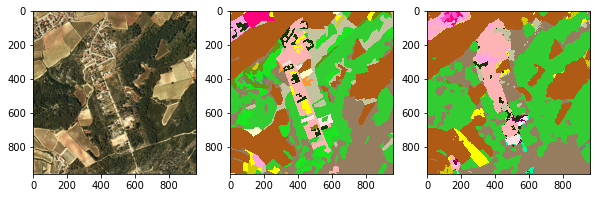

In [175]:
upsample_init = nn.Upsample((960,960), mode='bilinear', align_corners=False)
model.eval()
data = next(iter(test_loader))
labels, inputs_complete = data['landcover'],  torch.cat((data['orthophoto'],data['orthophotoIR'],upsample_init(data['sentinel1']),
                                                                       upsample_init(data['sentinel2april']), upsample_init(data['sentinel2april']), upsample_init(data['dsm'])),1)
inputs_complete = inputs_complete.to(device)

with torch.no_grad():
    outputs = model(inputs_complete)
    preds = torch.max(outputs, 1)[1].cpu()
    
fig, axs = plt.subplots(1,3,figsize=(10,3))
inputs_complete = np.moveaxis(inv_normalize(inputs_complete[0]).cpu().numpy(),0,2)
axs[0].imshow(saturate_plot(inputs_complete[...,0:3]))
axs[1].imshow(labels[0][0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')
axs[2].imshow(preds[0], cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')

In [176]:
from PIL import Image

im = Image.fromarray(np.uint8(saturate_plot(inputs_complete[...,0:3])*255))
im.save("pred_ortho.png")

im = Image.fromarray(np.uint8(cmap_mcsc(labels[0][0])*255))
im.save("pred_label.png")

im = Image.fromarray(np.uint8(cmap_mcsc(preds[0])*255))
im.save("pred_pred.png")

In [ ]:
upsample_init = nn.Upsample((960,960), mode='bilinear', align_corners=False) # gt images are 960x960 so we bring those small to this size too
model.eval()
with tqdm(test_loader) as t:
    for batch_idx, data in enumerate(t):
        with torch.no_grad():
            labels, inputs_complete = data['landcover'],  torch.cat((data['orthophoto'],data['orthophotoIR'],upsample_init(data['sentinel1']),
                                                                       upsample_init(data['sentinel2april']), upsample_init(data['sentinel2april']), upsample_init(data['dsm'])),1)   
            labels = torch.squeeze(labels.long(),1)
            labels = labels.to(device)
            
            inputs_complete = inputs_complete.to(device)
            
            outputs = model(inputs_complete)
            preds = torch.max(outputs, 1)[1]
            
            metrics = metric_collection(preds.cpu(), labels.cpu())
            
#             t.set_postfix({'Precision': metrics['Precision'].mean(),
#                            'Accuracy': metrics['Accuracy'].mean(),
#                            'Recall': metrics['Recall'].mean(),
#                            'IoU': metrics['IoU'].mean()})

  7%|▋         | 79/1135 [15:49<3:29:16, 11.89s/it]

In [67]:
a_file = open("metrics/metrics_complete.pkl", "wb")
pickle.dump(metric_collection.compute(), a_file)

## METRICS

In [8]:
with open('metrics/metrics_ortho.pkl', 'rb') as f:
    metrics_ortho = pickle.load(f)
with open('metrics/metrics_sentinel2.pkl', 'rb') as f:
    metrics_s2 = pickle.load(f)
with open('metrics/metrics_complete.pkl', 'rb') as f:
    metrics_complete = pickle.load(f)

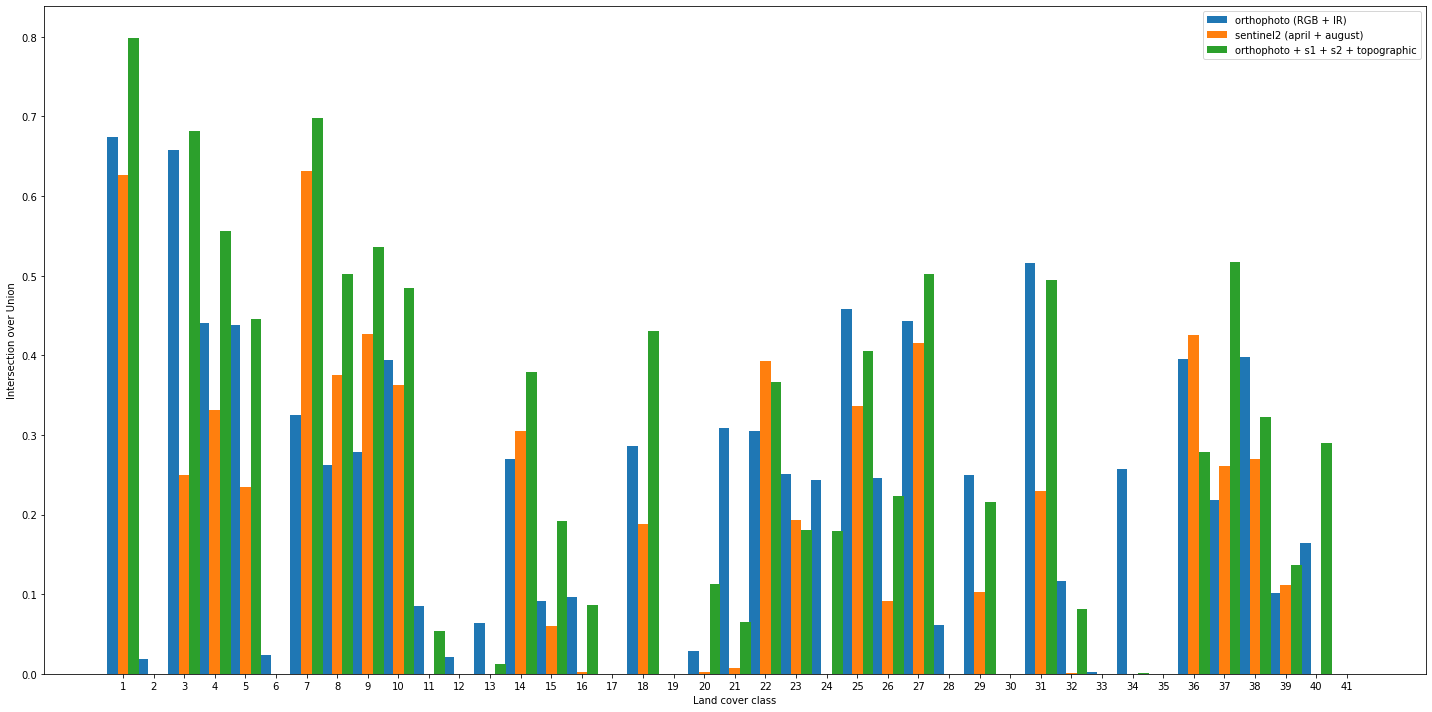

In [25]:
fig, ax = plt.subplots(figsize=(20,10)) 
width = 0.35
bar1=ax.bar(np.arange(1,42)-width,metrics_ortho['IoU'],width, label='orthophoto (RGB + IR)')
bar2=ax.bar(np.arange(1,42),metrics_s2['IoU'],width, label='sentinel2 (april + august)')
bar3=ax.bar(np.arange(1,42)+width,metrics_complete['IoU'],width, label='orthophoto + s1 + s2 + topographic')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Intersection over Union')
ax.set_xlabel('Land cover class')
ax.set_xticks(np.arange(1,42))
ax.set_xticklabels(np.arange(1,42))
ax.legend()

fig.tight_layout()
plt.show()

CustomExponential(accuracies[j,i])accuracies### Metrics ortho

In [50]:
# to print in the paper (latex)
# cm = metrics_ortho['ConfusionMatrix']
# accuracies = cm/cm.sum(0)

for i in range(41):
    print("{",end =" ")
    for j in range(41):
        if accuracies[j,i]!=0 and accuracies[j,i]>=0.01: print(f'"{accuracies[j,i]:.2f}"',end =", ")
        elif accuracies[j,i]!=0 and accuracies[j,i]<0.01: print(f'"{CustomExponential(accuracies[j,i])}"',end =", ")
        else: print("\" \"",end =", ")
    print("},")

print("----")
for i in range(41):
    print("{",end =" ")
    for j in range(41):
        if accuracies[j,i] == accuracies[j,i]:
            print(f'{100*accuracies[j,i]:.1f}',end =", ")
        else:
            print(0,end =", ")
    print("},")

{ "0.75", "e-2", "e-2", "e-2", "0.02", "e-2", "0.09", "0.02", "0.02", "0.02", "e-2", "e-3", "e-3", "0.02", "e-2", "e-2", "e-3", "e-2", "e-5", "e-2", "e-3", "e-4", "e-3", "e-2", "e-3", "e-2", "e-2", "e-3", "e-3", "e-3", "e-2", "e-2", "e-4", "e-3", "e-9", "e-3", "e-2", "e-3", "e-3", "e-2", "e-5", },
{ "0.02", "0.42", "e-3", " ", "e-2", " ", "e-2", " ", "e-4", "e-2", " ", " ", " ", "e-3", "e-4", " ", " ", " ", " ", " ", " ", " ", " ", "e-4", " ", "e-2", "0.46", "e-2", "e-2", "e-3", "e-3", "e-2", "e-3", "0.03", " ", "e-4", "e-2", " ", "0.04", "e-3", " ", },
{ "0.08", "e-3", "0.82", "0.01", "0.03", "0.01", "e-2", "e-3", "e-3", "0.01", "e-3", "e-5", "e-4", "e-2", "e-2", "e-2", "e-4", "e-4", "e-3", "e-3", "e-4", "e-5", "e-4", "e-3", "e-4", "e-3", "e-3", "e-4", "e-3", "e-3", "e-2", "e-3", "e-5", "e-4", " ", "e-5", "e-7", "e-6", "e-4", "e-4", " ", },
{ "e-2", "e-4", "e-2", "0.67", "0.10", "e-2", "0.07", "e-2", "e-2", "0.09", "0.02", "e-3", "e-2", "0.01", "e-4", "e-2", "e-3", "e-2", " ", "e-4", 

In [9]:
cm = metrics_ortho['ConfusionMatrix'].T

In [116]:
#1st col
cm_agriculture_agriculture = cm[0:6,0:6].sum(); cm_agriculture_forest = cm[0:6,6:20].sum(); cm_agriculture_urban = cm[0:6,20:35].sum(); cm_agriculture_water = cm[0:6,35:41].sum()
#2nd col
cm_forest_agriculture = cm[6:20,0:6].sum(); cm_forest_forest = cm[6:20,6:20].sum(); cm_forest_urban = cm[6:20,20:35].sum(); cm_forest_water = cm[6:20,35:41].sum()
#3rd col
cm_urban_agriculture = cm[20:35,0:6].sum(); cm_urban_forest = cm[20:35,6:20].sum(); cm_urban_urban = cm[20:35,20:35].sum(); cm_urban_water = cm[20:35,35:41].sum();
#4th col
cm_water_agriculture = cm[35:41,0:6].sum(); cm_water_forest = cm[35:41,6:20].sum(); cm_water_urban = cm[35:41,20:35].sum(); cm_water_water = cm[35:41,35:41].sum();

cm_4covers = np.array([[cm_agriculture_agriculture, cm_agriculture_forest, cm_agriculture_urban, cm_agriculture_water],
             [cm_forest_agriculture, cm_forest_forest, cm_forest_urban, cm_forest_water],
             [cm_urban_agriculture, cm_urban_forest, cm_urban_urban, cm_urban_water],
             [cm_water_agriculture, cm_water_forest, cm_water_urban, cm_water_water]])

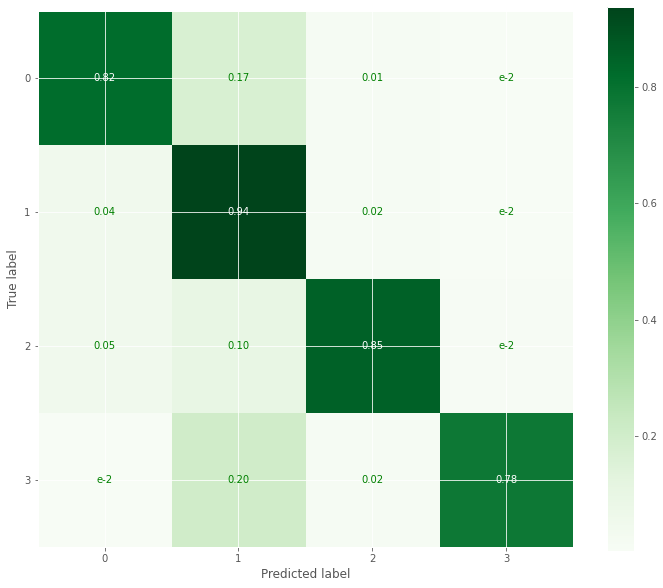

In [118]:
accuracies = cm_4covers/cm_4covers.sum(0)
fig, ax = plt.subplots(figsize=(12,10))
cb = ax.imshow(accuracies.T, cmap='Greens')
plt.xticks(range(4), range(4),rotation=0)
plt.yticks(range(4), range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(4):
    for j in range(4):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

plt.colorbar(cb, ax=ax)
plt.show()

In [29]:
precision = cm_4covers.diagonal() / cm_4covers.sum(0)
recall = cm_4covers.diagonal() / cm_4covers.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))

mIoU = [np.dot(metrics_ortho['IoU'][0:6],cm.sum(0)[0:6] / cm.sum(0)[0:6].sum()),
        np.dot(metrics_ortho['IoU'][6:20],cm.sum(0)[6:20] / cm.sum(0)[6:20].sum()),
        np.dot(metrics_ortho['IoU'][20:35],cm.sum(0)[20:35] / cm.sum(0)[20:35].sum()),
        np.dot(metrics_ortho['IoU'][35:41],cm.sum(0)[35:41] / cm.sum(0)[35:41].sum())]


print(f'precision: {precision},recall: {recall}, f1_score: {f1_score}, mIoU: {mIoU}')

precision: [0.89681274 0.909295   0.7508302  0.60171634],recall: [0.8188823  0.9377064  0.8507069  0.77578014], f1_score: [0.8560776 0.9232822 0.7976542 0.6777507], mIoU: [0.59826255, 0.30157703, 0.3323536, 0.3029794]


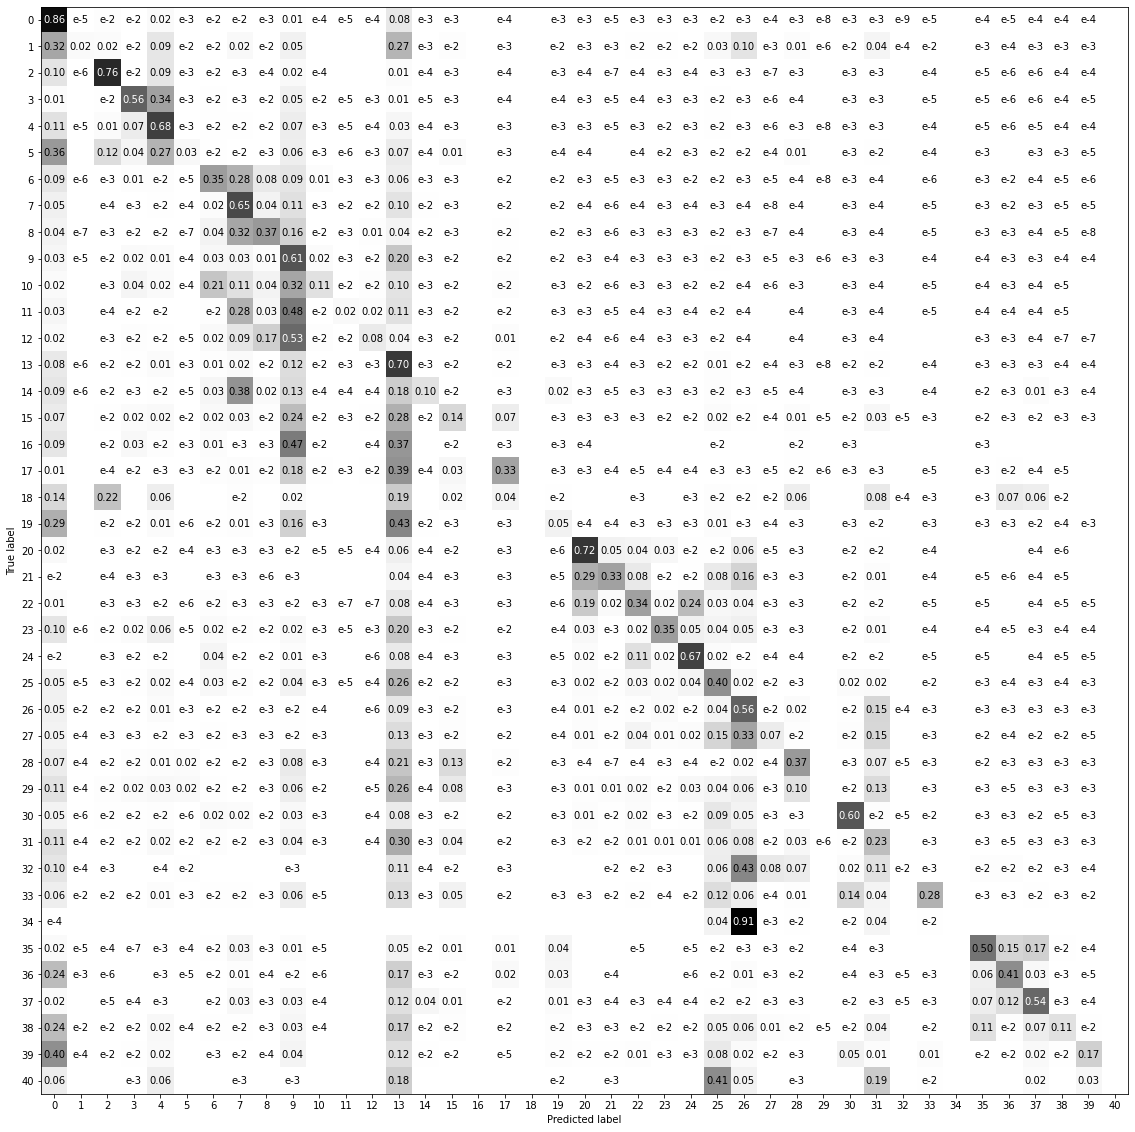

In [12]:
accuracies = cm/cm.sum(0)

fig, ax = plt.subplots(figsize=(20,20))
cb = ax.imshow(accuracies.T, cmap='gray_r')
ax.grid(False)
plt.xticks(range(41), range(41),rotation=0)
plt.yticks(range(41), range(41))
plt.ylabel('True label')
plt.xlabel('Predicted label')



for i in range(41):
    for j in range(41):
        color='black' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

In [67]:
precision = cm.diagonal() / cm.sum(0)
recall = cm.diagonal() / cm.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))

### Metrics sentinel2

In [26]:
cm = metrics_s2['ConfusionMatrix'].T

In [189]:
#1st col
cm_agriculture_agriculture = cm[0:6,0:6].sum(); cm_agriculture_forest = cm[0:6,6:20].sum(); cm_agriculture_urban = cm[0:6,20:35].sum(); cm_agriculture_water = cm[0:6,35:41].sum()
#2nd col
cm_forest_agriculture = cm[6:20,0:6].sum(); cm_forest_forest = cm[6:20,6:20].sum(); cm_forest_urban = cm[6:20,20:35].sum(); cm_forest_water = cm[6:20,35:41].sum()
#3rd col
cm_urban_agriculture = cm[20:35,0:6].sum(); cm_urban_forest = cm[20:35,6:20].sum(); cm_urban_urban = cm[20:35,20:35].sum(); cm_urban_water = cm[20:35,35:41].sum();
#4th col
cm_water_agriculture = cm[35:41,0:6].sum(); cm_water_forest = cm[35:41,6:20].sum(); cm_water_urban = cm[35:41,20:35].sum(); cm_water_water = cm[35:41,35:41].sum();

cm_4covers = np.array([[cm_agriculture_agriculture, cm_agriculture_forest, cm_agriculture_urban, cm_agriculture_water],
             [cm_forest_agriculture, cm_forest_forest, cm_forest_urban, cm_forest_water],
             [cm_urban_agriculture, cm_urban_forest, cm_urban_urban, cm_urban_water],
             [cm_water_agriculture, cm_water_forest, cm_water_urban, cm_water_water]])

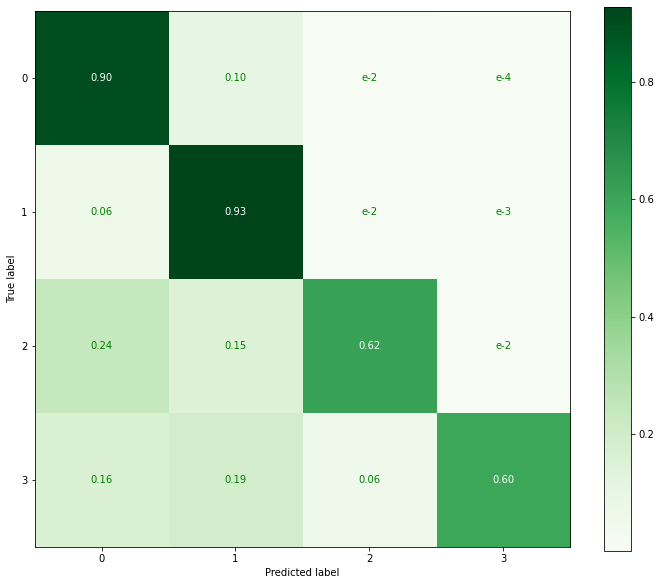

In [190]:
accuracies = cm_4covers/cm_4covers.sum(0)
fig, ax = plt.subplots(figsize=(12,10))
cb = ax.imshow(accuracies.T, cmap='Greens')
plt.xticks(range(4), range(4),rotation=0)
plt.yticks(range(4), range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(4):
    for j in range(4):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

plt.colorbar(cb, ax=ax)
plt.show()

In [165]:
precision = cm_4covers.diagonal() / cm_4covers.sum(0)
recall = cm_4covers.diagonal() / cm_4covers.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))

mIoU = [np.dot(metrics_s2['IoU'][0:6],cm.sum(0)[0:6] / cm.sum(0)[0:6].sum()),
        np.dot(metrics_s2['IoU'][6:20],cm.sum(0)[6:20] / cm.sum(0)[6:20].sum()),
        np.dot(metrics_s2['IoU'][20:35],cm.sum(0)[20:35] / cm.sum(0)[20:35].sum()),
        np.dot(metrics_s2['IoU'][35:41],cm.sum(0)[35:41] / cm.sum(0)[35:41].sum())]


print(f'precision: {precision},recall: {recall}, f1_score: {f1_score}, mIoU: {mIoU}')

precision: [0.89724195 0.9283905  0.61602813 0.5953081 ],recall: [0.82268524 0.94096166 0.8576032  0.8784822 ], f1_score: [0.85834765 0.93463385 0.7170147  0.7096906 ], mIoU: [0.49175104, 0.42546746, 0.21938038, 0.26573348]


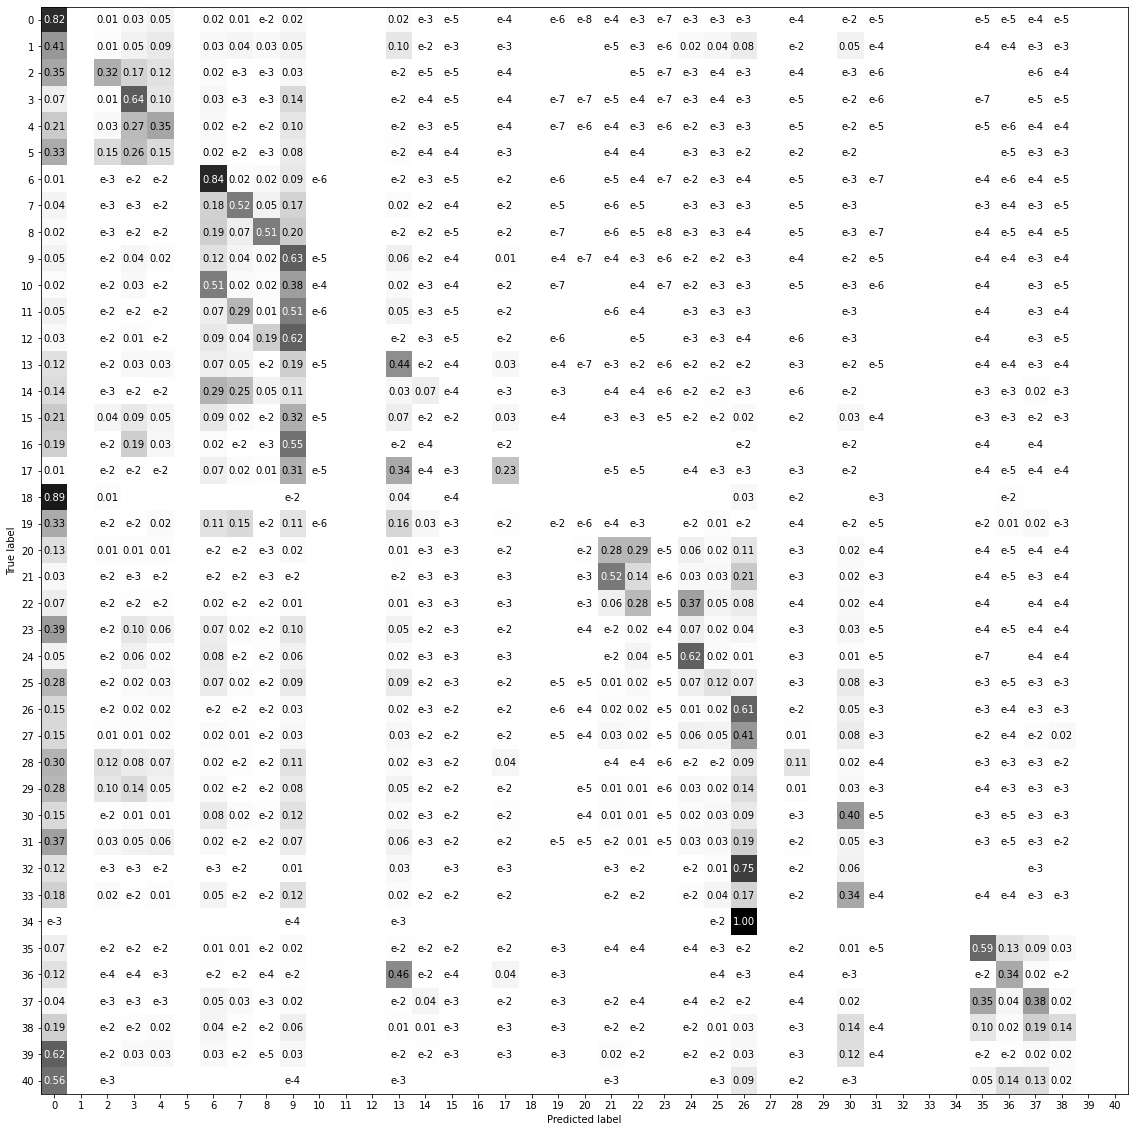

In [27]:
accuracies = cm/cm.sum(0)
fig, ax = plt.subplots(figsize=(20,20))
cb = ax.imshow(accuracies.T, cmap='gray_r')
plt.xticks(range(41), range(41),rotation=0)
plt.yticks(range(41), range(41))
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(41):
    for j in range(41):
        color='black' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

plt.show()


In [67]:
precision = cm.diagonal() / cm.sum(0)
recall = cm.diagonal() / cm.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))

### Metrics complete

In [22]:
cm = metrics_complete['ConfusionMatrix'].T

In [128]:
#1st col
cm_agriculture_agriculture = cm[0:6,0:6].sum(); cm_agriculture_forest = cm[0:6,6:20].sum(); cm_agriculture_urban = cm[0:6,20:35].sum(); cm_agriculture_water = cm[0:6,35:41].sum()
#2nd col
cm_forest_agriculture = cm[6:20,0:6].sum(); cm_forest_forest = cm[6:20,6:20].sum(); cm_forest_urban = cm[6:20,20:35].sum(); cm_forest_water = cm[6:20,35:41].sum()
#3rd col
cm_urban_agriculture = cm[20:35,0:6].sum(); cm_urban_forest = cm[20:35,6:20].sum(); cm_urban_urban = cm[20:35,20:35].sum(); cm_urban_water = cm[20:35,35:41].sum();
#4th col
cm_water_agriculture = cm[35:41,0:6].sum(); cm_water_forest = cm[35:41,6:20].sum(); cm_water_urban = cm[35:41,20:35].sum(); cm_water_water = cm[35:41,35:41].sum();

cm_4covers = np.array([[cm_agriculture_agriculture, cm_agriculture_forest, cm_agriculture_urban, cm_agriculture_water],
             [cm_forest_agriculture, cm_forest_forest, cm_forest_urban, cm_forest_water],
             [cm_urban_agriculture, cm_urban_forest, cm_urban_urban, cm_urban_water],
             [cm_water_agriculture, cm_water_forest, cm_water_urban, cm_water_water]])

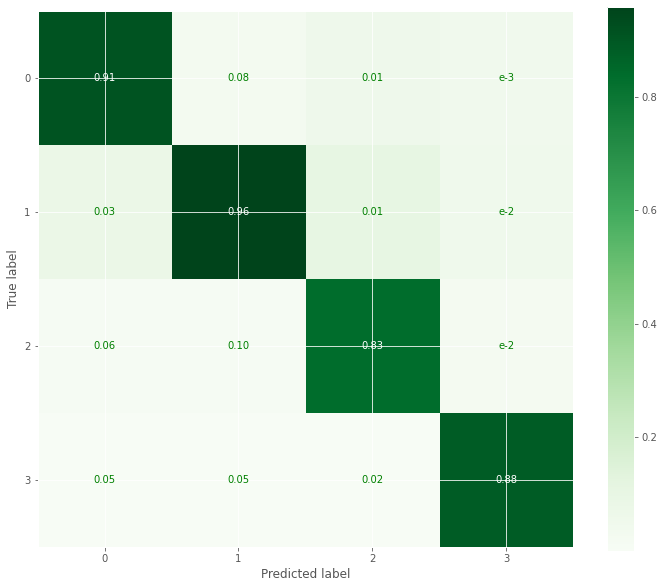

In [129]:
accuracies = cm_4covers/cm_4covers.sum(0)
fig, ax = plt.subplots(figsize=(12,10))
cb = ax.imshow(accuracies, cmap='Greens')
plt.xticks(range(4), range(4),rotation=0)
plt.yticks(range(4), range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(4):
    for j in range(4):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

plt.colorbar(cb, ax=ax)
plt.show()

In [169]:
precision = cm_4covers.diagonal() / cm_4covers.sum(0)
recall = cm_4covers.diagonal() / cm_4covers.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))

mIoU = [np.dot(metrics_complete['IoU'][0:6],cm.sum(0)[0:6] / cm.sum(0)[0:6].sum()),
        np.dot(metrics_complete['IoU'][6:20],cm.sum(0)[6:20] / cm.sum(0)[6:20].sum()),
        np.dot(metrics_complete['IoU'][20:35],cm.sum(0)[20:35] / cm.sum(0)[20:35].sum()),
        np.dot(metrics_complete['IoU'][35:41],cm.sum(0)[35:41] / cm.sum(0)[35:41].sum())]


print(f'precision: {precision},recall: {recall}, f1_score: {f1_score}, mIoU: {mIoU}')

precision: [0.91208714 0.9572707  0.8341379  0.88323   ],recall: [0.919574   0.956961   0.80812895 0.8356498 ], f1_score: [0.91581523 0.9571158  0.82092744 0.8587814 ], mIoU: [0.6939172, 0.52204883, 0.3092848, 0.32604632]


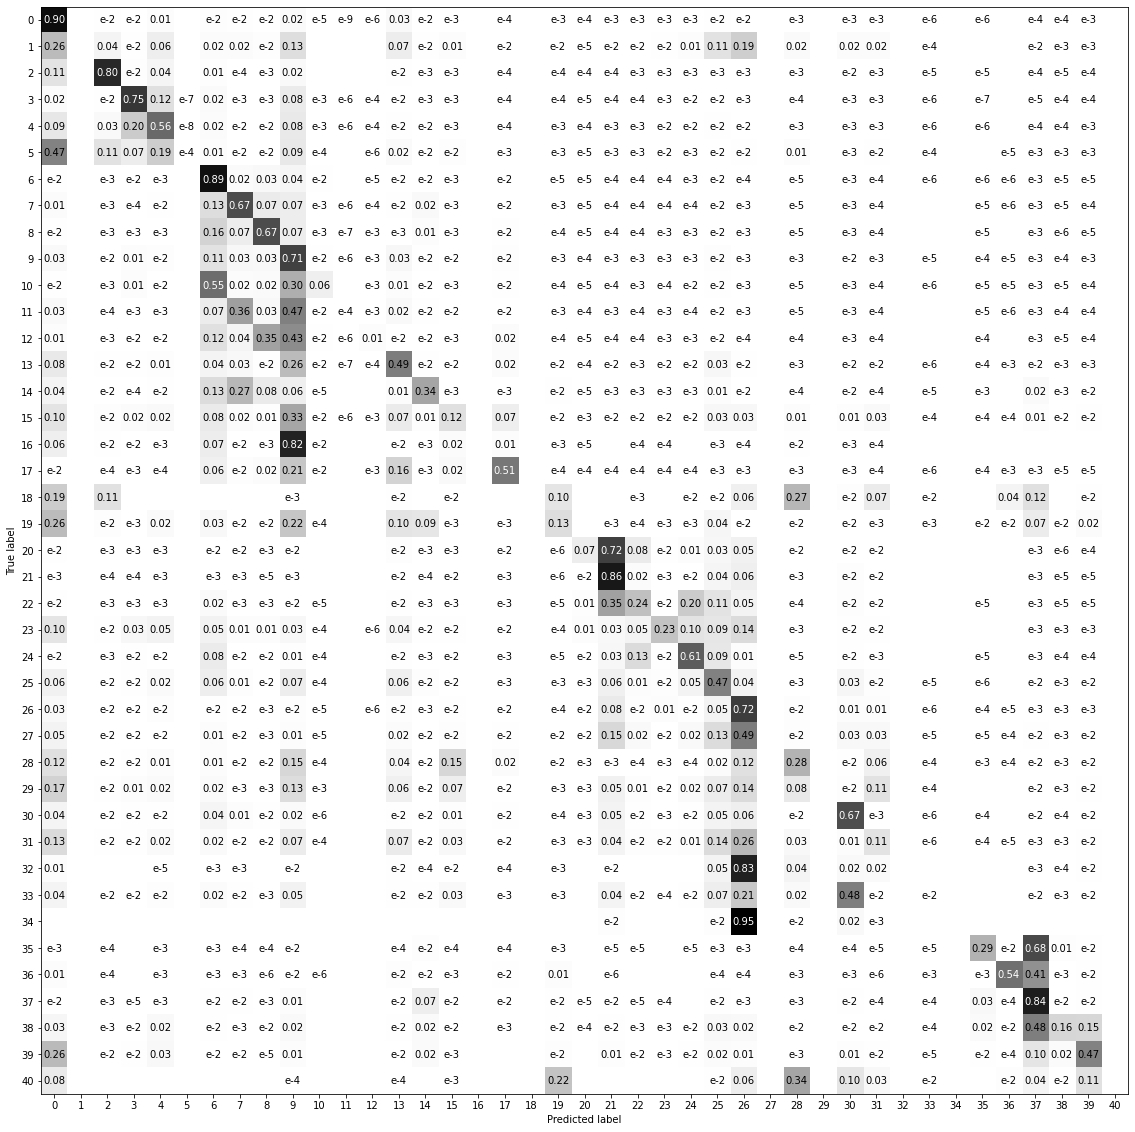

In [25]:
accuracies = cm/cm.sum(0)
fig, ax = plt.subplots(figsize=(20,20))
cb = ax.imshow(accuracies.T, cmap='gray_r')
plt.xticks(range(41), range(41),rotation=0)
plt.yticks(range(41), range(41))
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(41):
    for j in range(41):
        color='black' if accuracies[i,j] < 0.5 else 'white'
        if accuracies[i,j]!=0 and accuracies[i,j]>=0.01: ax.annotate(f'{accuracies[i,j]:.2f}', (i,j), color=color, va='center', ha='center')
        elif accuracies[i,j]!=0 and accuracies[i,j]<0.01: ax.annotate(CustomExponential(accuracies[i,j]), (i,j), color=color, va='center', ha='center')
            #ax.annotate(CustomExponential(cm[i,j]), (i,j), color=color, va='center', ha='center')

plt.show()


In [67]:
precision = cm.diagonal() / cm.sum(0)
recall = cm.diagonal() / cm.sum(1)
f1_score = 2*((precision*recall)/(precision+recall))